# 2025-02-17 Nonlinear solvers

## Last time

* Cost of linear solvers
* Assembling sparse matrices
* Rootfinding intro
* Newton's method for systems

## Today

* Bratu nonlinear PDE

In [2]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end


function advdiff_sparse(n, kappa, wind, forcing)
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    rows = [1, n]
    cols = [1, n]
    vals = [1., 1.] # diagonals entries (float)
    rhs[[1,n]] .= 0 # boundary condition
    for i in 2:n-1
        flux_L = -kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])
        flux_R = -kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])
        weights = fdstencil(xstag[i-1:i], x[i], 1)
        append!(rows, [i,i,i])
        append!(cols, i-1:i+1)
        append!(vals, weights[1] *  [flux_L..., 0] + weights[2] * [0, flux_R...])
    end
    L = sparse(rows, cols, vals)
    x, L, rhs
end

advdiff_sparse (generic function with 1 method)

## Newton-Raphson Method

Much of numerical analysis reduces to [Taylor series](https://en.wikipedia.org/wiki/Taylor_series), the approximation
$$ f(x) = f(x_0) + f'(x_0) (x-x_0) + f''(x_0) (x - x_0)^2 / 2 + \underbrace{\dotsb}_{O((x-x_0)^3)} $$
centered on some reference point $x_0$.

In numerical computation, it is exceedingly rare to look beyond the first-order approximation
$$ \tilde f_{x_0}(x) = f(x_0) + f'(x_0)(x - x_0) . $$
Since $\tilde f_{x_0}(x)$ is a linear function, we can explicitly compute the unique solution of $\tilde f_{x_0}(x) = 0$ as
$$ x = x_0 - f(x_0) / f'(x_0) . $$
This is Newton's Method (aka Newton-Raphson or Newton-Raphson-Simpson) for finding the roots of differentiable functions.

# An implementation

In [46]:
function newton(f, fp, x0; tol=1e-8, verbose=false)
    x = x0
    for k in 1:100 # max number of iterations
        fx = f(x)
        fpx = fp(x)
        if verbose
            println("[$k] x=$x  f(x)=$fx  f'(x)=$fpx")
        end
        if abs(fx) < tol
            return x, fx, k
        end
        x = x - fx / fpx
    end  
end
eps = 1
newton(x -> eps*(cos(x) - x), x -> eps*(-sin(x) - 1), 1; tol=1e-15, verbose=true)

[1] x=1  f(x)=-0.45969769413186023  f'(x)=-1.8414709848078965
[2] x=0.7503638678402439  f(x)=-0.018923073822117442  f'(x)=-1.6819049529414878
[3] x=0.7391128909113617  f(x)=-4.6455898990771516e-5  f'(x)=-1.6736325442243012
[4] x=0.739085133385284  f(x)=-2.847205804457076e-10  f'(x)=-1.6736120293089505
[5] x=0.7390851332151607  f(x)=0.0  f'(x)=-1.6736120291832148


(0.7390851332151607, 0.0, 5)

# That's really fast!

* 10 digits of accuracy in 4 iterations.
* How is this convergence test different from the one we used for bisection?
* How can this break down?

$$ x_{k+1} = x_k - f(x_k)/f'(x_k) $$

In [47]:
newton(x -> cos(x) - x, x -> -sin(x) - 1, 3pi/2 + 0.001; verbose=true)

[1] x=4.71338898038469  f(x)=-4.712388980551356  f'(x)=-4.999999583255033e-7
[2] x=-9.424774033259554e6  f(x)=9.424773326519862e6  f'(x)=-0.292526319358701
[3] x=2.2793774188936606e7  f(x)=-2.2793773685912155e7  f'(x)=-0.1357278194645779
[4] x=-1.451436005941369e8  f(x)=1.4514359959518498e8  f'(x)=-0.954228185423985
[5] x=6.962155463251442e6  f(x)=-6.962156426217826e6  f'(x)=-1.2696214789257265
[6] x=1.4785081386104291e6  f(x)=-1.4785074154248144e6  f'(x)=-0.30934627585724994
[7] x=-3.3009494815843664e6  f(x)=3.3009485852473797e6  f'(x)=-0.5566265608245774
[8] x=2.6293255314466488e6  f(x)=-2.629324971066165e6  f'(x)=-1.8282353007342522
[9] x=1.191149072426204e6  f(x)=-1.1911491529894928e6  f'(x)=-1.996749495363329
[10] x=594604.9612317495  f(x)=-594605.3799884742  f'(x)=-1.9080984558468124
[11] x=282983.00159623957  f(x)=-282982.3813435215  f'(x)=-1.7844020434228265
[12] x=124396.32972676173  f(x)=-124396.58315146118  f'(x)=-1.9673551166508052
[13] x=61165.964197618225  f(x)=-61165.300

(0.7390851332151614, -1.3322676295501878e-15, 83)

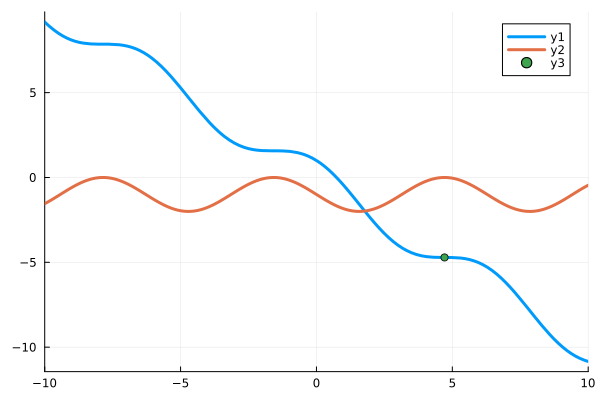

In [8]:
plot(x -> cos(x) - x, xlim = (-10, 10))
plot!(x -> -sin(x) - 1)
scatter!([3pi/2 + 0.001], [cos(3pi/2 + 0.001) - (3pi/2 + 0.001)] )

# Convergence of fixed-point iteration

Consider the iteration
$$x_{k+1} = g(x_k)$$
where $g$ is a continuously differentiable function.
Suppose that there exists a fixed point $x_* = g(x_*)$.  By the [mean value theorem](https://en.wikipedia.org/wiki/Mean_value_theorem), we have that
$$ x_{k+1} - x_* = g(x_k) - g(x_*) = g'(c_k) (x_k - x_*) $$
for some $c_i$ between $x_k$ and $x_*$.

Taking absolute values, $$|e_{k+1}| = |g'(c_k)| |e_k|,$$ which converges to zero if $|g'(c_k)| < 1$.

## Exercise

* Write Newton's method for finding the roots of $f(x)$ from initial guess $x_0$ as a fixed point method.
* Suppose the Newton iterates $x_k$ converge to a simple root $x_*$, $x_k \to x_*$. What is $\lvert g'(x_*) \rvert$ for Newton's method?

## Solution

* for Newton's method, $x_{k+1} = \underbrace{x_k - \frac{f(x_k)}{f'(x_k)}}_{g(x_k)}$
* at $x_k = x_*$, $g'(x_*) = 1 - \frac{f'(x_*)}{f'(x_*)} + \frac{f(x_*)f''(x_*)}{(f'(x_*))^2} = 0$ due to $x_*$ being a simple root.

# Newton for systems of equations

Let $\mathbf u \in \mathbb R^n$ and consider the function $\mathbf f(\mathbf u) \in \mathbb R^n$. Then
$$ \mathbf f(\mathbf u) = \mathbf f(\mathbf u_0) + \underbrace{\mathbf f'(\mathbf u_0)}_{n\times n} \underbrace{\mathbf \delta \mathbf u}_{n\times 1} + \frac 1 2 \underbrace{\mathbf f''(\mathbf u_0)}_{n\times n \times n} {(\delta \mathbf u)^2}_{n\times n} + O(|\delta\mathbf u|^3).$$

We drop all but the first two terms and name the Jacobian matrix $J(\mathbf u) = \mathbf f'(\mathbf u)$ (with $\mathbf{J}_{ij} = \frac{\partial \mathbf{f}_i}{\partial \mathbf{u}_j}$),
$$ \mathbf f(\mathbf u) \approx \mathbf f(\mathbf u_0) + J \delta \mathbf u .$$
Solving the right hand side equal to zero yields
\begin{align}
J \delta \mathbf u &= -\mathbf f(\mathbf u_k) \\
\mathbf u_{k+1} &= \mathbf u_k + \delta \mathbf u
\end{align}

# Newton in code


In [49]:
function newton(residual, jacobian, u0; maxits=20)
    u = u0
    uhist = [copy(u)]
    normhist = []
    for k in 1:maxits
        f = residual(u)
        push!(normhist, norm(f))
        J = jacobian(u)
        delta_u = - J \ f
        u += delta_u
        push!(uhist, copy(u))
    end
    uhist, normhist
end

newton (generic function with 1 method)

(21,)

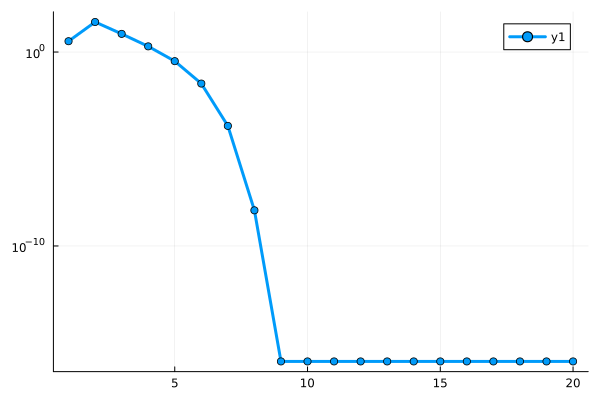

In [64]:
function residual(u)
    x, y = u
    [x^2 + y^2 - 1, x^2 - y]
end
function jacobian(u)
    x, y = u
    [2x 2y; 2x -1]
end

uhist, normhist = newton(residual, jacobian, [0.1, 2])
print(uhist.size)
plot(normhist, marker=:circle, yscale=:log10)

# Plotting the trajectory

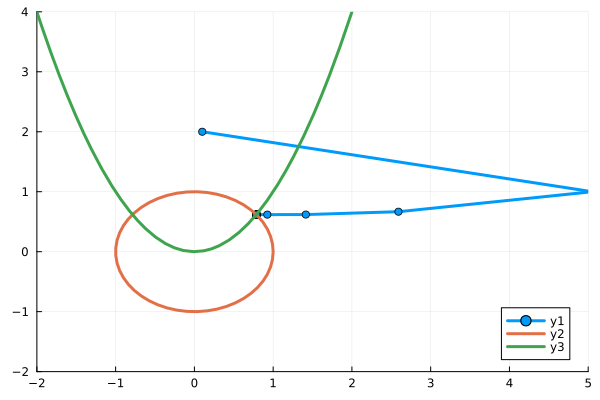

In [65]:
xy = hcat(uhist...) # hcat is horizontal concatenation
plot(xy[1,:], xy[2,:], marker=:circle)
circle = exp.(1im*LinRange(0, 2*pi, 50))
plot!(real(circle), imag(circle))
plot!(x -> x^2, xlims=(-2, 5), ylims=(-2, 4), axes=:equal, legend=:bottomright)
# Question: what if I started from u = [-0.1, 2]? How about [0, 2]?

# Bratu problem

$$-(u_x)_x - \lambda e^{u}= 0$$

* Arises in physics: 
    * fuel ignition model of thermal combustion
    * radiative heat transfer
    * Chandrasekhar model of expansion of the Universe

* General form 
\begin{align}
\Delta u + c e^u &= 0 \quad \text{in } \Omega, \\
u &= 0 \quad \text{on } \partial \Omega
\end{align}
    * $\Omega$ is a bounded domain in $\mathbb{R}^n$, $\partial \Omega$ is its boundary
    

* 1D form
\begin{align}
 u_{xx} + c e^u &= 0 \quad 0 \leq x \leq 1 \\
u(0) = u(1) &= 0
\end{align}

* Solid fuel ignition model:
\begin{align}
u_t = \Delta u + \lambda(1 - \varepsilon u)^m e^{u/(1 + \varepsilon u)} &= 0 \quad \text{in } \Omega, \\
u &= 0 \quad \text{on } \partial \Omega
\end{align}
    * $v$ is dimensionless temperature
    * $1/\varepsilon$ is activation energy
    * $\lambda$ is a known parameter
* **Question**: take $\varepsilon << 1$. What physical processes give rise to the terms in the equation? How do they keep balance? 
    * _Hint_: Think back to equations we covered to identify the first term. The second term is called the "reaction term" (will discuss)
    * What do you qualitatively expect to happen at large $\lambda$ and at late times $t$? How about small $\lambda$?

\begin{align}
-(u_x)_x - \lambda e^{u} &= 0, \quad x \in [-1, 1] \\
 u(-1) &= 0 \\
u(1) &= 1
\end{align}

In [53]:
# f in the root finding problem
function bratu_f(u; lambda=.5)
    n = length(u)
    h = 2 / (n - 1) # Equispaced discretization of x
    weights = -fdstencil([-h, 0, h], 0, 2) # Centered difference second derivative, note negative sign!
    u = copy(u)
    f = copy(u)
    u[1] = 0
    u[n] = 1 # Boundary conditions for u
    f[n] -= 1 
    for i in 2:n-1
        f[i] = weights * u[i-1:i+1] - lambda * exp(u[i])
    end
    f
end

bratu_f (generic function with 1 method)

In [61]:
# Jacobian
function bratu_J(u; lambda=.7)
    n = length(u)
    h = 2 / (n - 1)
    weights = -fdstencil([-h, 0, h], 0, 2)
    # Using the COO representation
    rows = [1, n]
    cols = [1, n]
    vals = [1., 1.] # diagonals entries (float)
    for i in 2:n-1
        append!(rows, [i,i,i])
        append!(cols, i-1:i+1)
        append!(vals, weights + [0 -lambda*exp(u[i]) 0])
    end
    sparse(rows, cols, vals)
end

bratu_J (generic function with 1 method)

# Solving Bratu

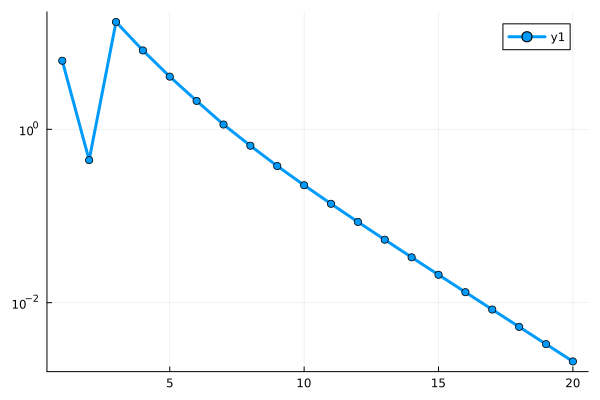

In [62]:
n = 50
x = collect(LinRange(-1., 1, n))
u0 = (1 .+ x) ./ 2
uhist, normhist = newton(bratu_f, bratu_J, u0);

plot(normhist, marker=:circle, yscale=:log10)

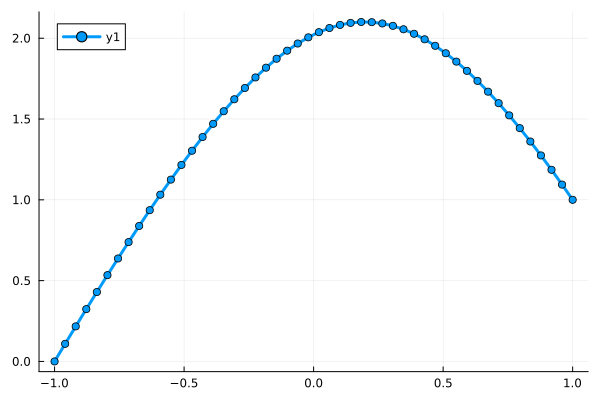

In [63]:
plot(x, uhist[end], marker=:circle)